In [4]:
import torch

#@markdown ### **Imports**
# diffusion policy import
from imports import *

In [5]:
#@markdown ### **Environment**
#@markdown Defines a PyMunk-based Push-T environment `PushTEnv`.
#@markdown 
#@markdown **Goal**: push the gray T-block into the green area.
#@markdown
#@markdown Adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/)


positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x
    
When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y
    
"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

from draw import DrawOptions

def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
from PushTEnv import PushTEnv


In [5]:
#@markdown ### **Env Demo**
#@markdown Standard Gym Env (0.21.0 API)

# 0. create env object
env = PushTEnv()

# 1. seed env for initial state. 
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, done, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("Obs: ", repr(obs))
    print("Obs:        [agent_x,  agent_y,  block_x,  block_y,    block_angle]")
    print("Action: ", repr(action))
    print("Action:   [target_agent_x, target_agent_y]")



Obs:  array([123.1774, 114.5621, 292.    , 351.    ,   2.9196])
Obs:        [agent_x,  agent_y,  block_x,  block_y,    block_angle]
Action:  array([90.25  , 99.2261])
Action:   [target_agent_x, target_agent_y]


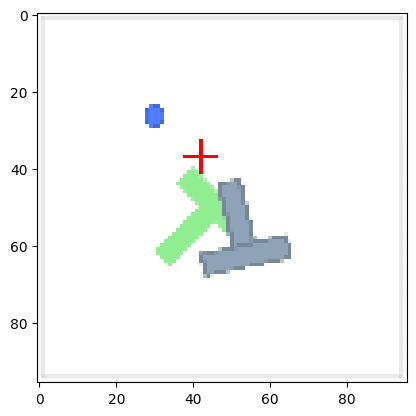

In [4]:
import matplotlib.pyplot as plt

plt.imshow(env.render(mode = 'rgb_array'))

In [7]:
#@markdown ### **Dataset Demo**
from PushTDataset import *

# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True, 
    # don't kill worker process afte each epoch
    persistent_workers=True 
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([256, 2, 5])
batch['action'].shape torch.Size([256, 16, 2])


In [10]:
from Components import *

#@markdown ### **Network Demo**

# observation and action dimensions corrsponding to
# the output of PushTEnv
obs_dim = 4
action_dim = 2

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action, 
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise 
# the actual noise removal is performed by NoiseScheduler 
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.532455e+07


In [ ]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    model=noise_pred_net,
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(), 
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, 
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)
                
                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)
                
                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = ema.averaged_model

In [11]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  ckpt_path = "model_99"
  if not os.path.isfile(ckpt_path):
      id = "1mHDr_DEZSdiGo9yecL50BBQYzR8Fjhl_&confirm=t"
      gdown.download(id=id, output=ckpt_path, quiet=False)

  state_dict = torch.load(ckpt_path, map_location='cuda')
  ema_noise_pred_net = noise_pred_net
  ema_noise_pred_net.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

Pretrained weights loaded.


In [29]:
# Ts = 0.05  # discrete simulation time step
#
# # dynamic matrices for double integrator system
# A = torch.Tensor([[1.0, Ts, 0, 0],
#               [0, 1.0, 0, 0],
#               [0, 0, 1.0, Ts],
#               [0, 0, 0, 1.0]])
# n_state = 4
# B = torch.Tensor([[0,0],
#               [Ts,0],
#               [0,0],
#               [0,Ts]])
# n_input = 2
# # goal state (origin with zero velocity)
# x_target = torch.Tensor([[0],
#                      [0],
#                      [0],
#                      [0]])

Ts = 0.05  # discrete simulation time step

# dynamic matrices for double integrator system
A_mat = np.array([[1.0, Ts, 0, 0],
              [0, 1.0, 0, 0],
              [0, 0, 1.0, Ts],
              [0, 0, 0, 1.0]])
n_state = 4
B_mat = np.array([[0,0],
              [Ts,0],
              [0,0],
              [0,Ts]])
n_input = 2
# goal state (origin with zero velocity)
x_target = np.array([[0],
                     [0],
                     [0],
                     [0]])

In [56]:
#@markdown ### **Inference**

# limit enviornment interaction to 200 steps before termination
max_steps = 300
# env = PushTEnv()
# # use a seed >200 to avoid initial states seen in the training dataset
# env.seed(100000)
#
# # get first observation
# obs = env.reset()

from PushTDataset import *
# dataset_pushT = load_dataset_push_t()
dataset_LQR = load_dataset_LQR()

stats = dataset_LQR.stats

# get first observation
obs = np.random.random(4)*10-5
obs[1] = 0
obs[3] = 0

OBS = []
ACTION_PRED = []
############ obs
# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
# imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # infer action
        with torch.no_grad():
            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = torch.randn(
                (B, pred_horizon, action_dim), device=device)
            naction = noisy_action
            
            # init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = ema_noise_pred_net(
                    sample=naction, 
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample


        # unnormalize action
        naction = naction.detach().to('cpu').numpy()

        # print('naction: ', action_pred.shape)
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # print('action_pred: ', action_pred.shape)

        # only take action_horizon number of actions
        start = obs_horizon - 1 # obs horizon is 2
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)
        # print('action_pred: ', action.shape)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            # print(obs.shape, action[i].shape) #, next_obs.shape)
            # print(A_mat.shape, B_mat.shape)
            OBS.append(obs)
            ACTION_PRED.append(action[i])

            obs = A_mat@obs + B_mat@action[i]

            # next_rew =
            # done = next_rew < 1
            # print(obs, action[i], next_obs)
            dist = np.linalg.norm([obs[0], obs[2]])
            rew_enable = dist < 1

            reward = rew_enable*(1- dist)
            done = reward > 0.95 and (obs[1]**2 + obs[3]**2) < 0.1
            # obs, reward, done, info = env.step(action[i])
            # # save observations
            # obs_deque.append(obs)
            # x, xdot, y, ydot
            obs_deque.append(obs)


            # and reward/vis
            rewards.append(reward)
            # imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
# from IPython.display import Video
# vwrite('vis.mp4', imgs)
# Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTStateEnv:   0%|          | 0/300 [00:00<?, ?it/s]

Score:  0.9510622562243216


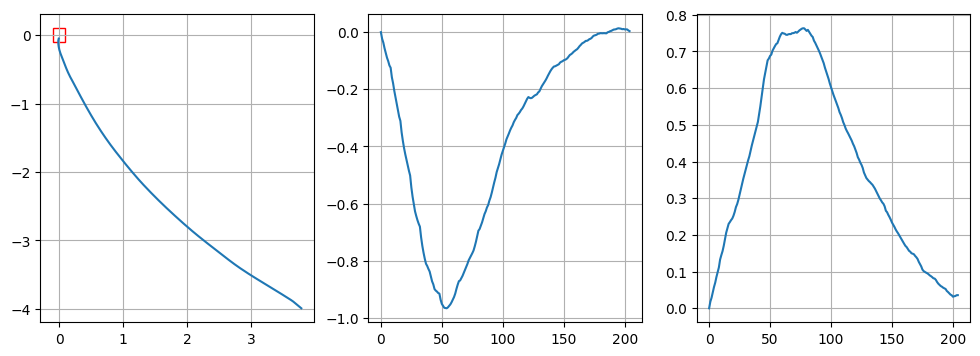

In [62]:
import matplotlib.patches as patches

OBS = np.array(OBS)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.plot(OBS[:,0], OBS[:,2]); ax1.grid()
ax2.plot(OBS[:,1]); ax2.grid()
ax3.plot(OBS[:,3]); ax3.grid()
rect = patches.Rectangle((-0.1, -0.1), 0.2, 0.2, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect)


In [47]:
OBS

array([[-2.66833174e+00,  3.54354785e+00,  1.50327594e+00,
        -3.04734086e-01],
       [-2.49115434e+00,  3.41536027e+00,  1.48803923e+00,
        -4.02705579e-01],
       [-2.32038633e+00,  3.27804157e+00,  1.46790395e+00,
        -4.81116165e-01],
       [-2.15648425e+00,  3.14101873e+00,  1.44384814e+00,
        -5.48761448e-01],
       [-1.99943332e+00,  3.00105155e+00,  1.41641007e+00,
        -6.03905842e-01],
       [-1.84938074e+00,  2.86030990e+00,  1.38621478e+00,
        -6.39295669e-01],
       [-1.70636524e+00,  2.72461430e+00,  1.35425000e+00,
        -6.68397667e-01],
       [-1.57013453e+00,  2.59256186e+00,  1.32083011e+00,
        -7.00563908e-01],
       [-1.44050643e+00,  2.46750962e+00,  1.28580192e+00,
        -7.20696251e-01],
       [-1.31713095e+00,  2.34119755e+00,  1.24976711e+00,
        -7.45568367e-01],
       [-1.20007108e+00,  2.22341066e+00,  1.21248869e+00,
        -7.66406711e-01],
       [-1.08890054e+00,  2.10143234e+00,  1.17416835e+00,
      